In [82]:
import os
import sys
import numpy as np
import pandas as pd
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.metrics import(
    mean_absolute_error, 
    r2_score,
    mean_absolute_percentage_error,
)
from xgboost import XGBRegressor

from src.features import cnbv_inclusion_financiera
from src.data import banxico_mun_income_remittances


In [48]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 100)

In [2]:
prj_dir = os.path.abspath(os.getcwd() + '/..')
print(prj_dir)
sys.path.append(prj_dir)

/mnt/c/Users/dhdzm/Documents/proyects/rulo_mota_omath


In [3]:
remittances_df = banxico_mun_income_remittances.get()
remittances_df['remittance_id'] = (
    remittances_df['Municipality ID'].astype(str)
) + '-' + (
    remittances_df['Year'].astype(str))

In [4]:
y_true = remittances_df.set_index('remittance_id')['Remittance Amount']
y_true = np.log1p(y_true)

In [5]:
data_paths = dict(
    (x.split('/')[-1], x)
    for x in cnbv_inclusion_financiera.list_datasets())


In [86]:
datasets = {}
for dataset_name, path in data_paths.items():
    if dataset_name=='Municipios.csv':
        continue
    data = pd.read_csv(path, low_memory=False)
    data['name'] = data['name'].apply(lambda x: x.replace('%20', '_'))
    if 'informacion_general__clave_municipio' in data.columns:
        municipio_feature = 'informacion_general__clave_municipio'
    elif 'clave_de_estado_y_municipio' in data.columns:
        municipio_feature = 'clave_de_estado_y_municipio'
    else:
        municipio_feature = 'clave_municipio'
    datasets[dataset_name] = data
    data['year_month'] = data['name'].apply(
        lambda x: x.split('_')[-1].replace('.csv', '')[:6]
    ).astype(int)
    data['year'] = data['name'].apply(
        lambda x: x.split('_')[-1].replace('.csv', '')[:4]
    ).astype(int)
    data['remittance_year'] = data['year'] + 1

    try:
        data['dataset_id'] = (
            data[municipio_feature].astype(int).astype(str) +
            '_' + 
            data['year_month'].astype(str)
        )
        data['remittance_id'] = data[municipio_feature].astype(int).astype(str)
        data['remittance_id'] += '-' + data['remittance_year'].astype(str)
    except: 
        pass


In [87]:
important_document_names = [
    key for key in datasets.keys() if
    'Infraestructura' in key or
    'Tenencia' in key or
    'Género' in key
]
important_document_names

['BD Género Mun.csv',
 'BD Infraestructura Mun.csv',
 'BD Tenencia Uso Banca Mun.csv',
 'BD Tenencia Uso EACP Mun.csv']

In [88]:
merged_data = datasets['BD Género Mun.csv'].merge(
    datasets['BD Infraestructura Mun.csv'], 
    suffixes=(None, '__duplicate'), 
    on='dataset_id'
)
merged_data.drop([col for col in merged_data if '__duplicate' in col], axis=1, inplace=True)
merged_data = datasets['BD Género Mun.csv'].merge(
    datasets['BD Tenencia Uso Banca Mun.csv'],
    suffixes=(None, '__duplicate'), 
    on='dataset_id'
)
merged_data.drop([col for col in merged_data if '__duplicate' in col], axis=1, inplace=True)
merged_data = datasets['BD Género Mun.csv'].merge(
    datasets['BD Tenencia Uso EACP Mun.csv'],
    suffixes=(None, '__duplicate'), 
    on='dataset_id'
)
merged_data.drop([col for col in merged_data if '__duplicate' in col], axis=1, inplace=True)

merged_data = merged_data.replace('-', np.nan)

null_vals = merged_data.isna().sum()/merged_data.shape[0]
null_vals = null_vals[null_vals > 0.001].index
merged_data = merged_data.drop(null_vals, axis=1)

In [89]:
merged_data = merged_data[merged_data.informacion_general__clave_municipio < 33000]

In [90]:
feature_cols = [
    'ahorro',
    'plazo', 
    'n1',
    'n2',
    'n3', 
    'transaccionales_tradicionales',
    'total',
    'hipotecarios',
    'credito',
    'transacciones',
    'clientes_-_sofipo',
    'socios_-_socap',
    'total_de_usuarios_-_eacp'
]

In [91]:
features_to_columns = [
    col for col in merged_data.columns if 
    any([col.startswith(f) for f in feature_cols ])
]

In [92]:
def obtain_general_year_tendency(df):
    df = df.sort_values('date')
    reduced_info = df[features_to_columns]
    first = reduced_info.iloc[0]
    last = reduced_info.iloc[-1]
    vector = last-first
    vector.index = [col + '_mean_tendency' for col in vector.index]
    return vector

In [93]:
tendency = merged_data.groupby(
    ['informacion_general__clave_municipio', 'year']
).apply(obtain_general_year_tendency)
tendency = tendency.reset_index()

In [94]:
def obtain_mean_tendency(df):
    mean_tendency_dict = {}
    for col in features_to_columns:
        mean_tendency_dict[col + '_mean_tendency'] =  np.gradient(
            df[col]
        ).mean()
    return pd.Series(mean_tendency_dict)

In [95]:
mean_tendency = merged_data.groupby(
    ['informacion_general__clave_municipio', 'year']
).apply(obtain_mean_tendency)
mean_tendency = mean_tendency.reset_index()

In [96]:
tendency['remittance_id'] = (
            tendency['informacion_general__clave_municipio'].astype(int).astype(str) +
            '-' + 
            (tendency['year'] + 1).astype(str)
        )
mean_tendency['remittance_id'] = (
            mean_tendency['informacion_general__clave_municipio'].astype(int).astype(str) +
            '-' + 
            (mean_tendency['year'] + 1).astype(str)
        )

In [128]:
population = [col for col in md.columns if 'informacion_general__poblacion' in col]

In [129]:
md = merged_data.copy()

md = md.drop(population, axis=1,)


for col in md.select_dtypes('number').columns:
    if col == 'year':
        pass
    else:
        md[col] = np.log1p(md[col])
md = md.merge(
    mean_tendency, 
    on='remittance_id',
    how='left', 
    suffixes=(None, '__duplicate')
)
md.drop(
    [col for col in md if '__duplicate' in col],
    axis=1, 
    inplace=True
)
md = md.merge(
    tendency, 
    on='remittance_id',
    how='left', 
    suffixes=(None, '__duplicate'), 
)
md.drop(
    [col for col in md if '__duplicate' in col],
    axis=1, 
    inplace=True
)

In [130]:
general_region_info_dict = dict(
    md.informacion_general__region.value_counts())
for i, key in enumerate(general_region_info_dict.keys()):
    general_region_info_dict[key] = i
#general_population_type_info = dict(
#    md.informacion_general__tipo_de_poblacion.value_counts())
#for i, key in enumerate(general_population_type_info.keys()):
#    general_population_type_info[key] = i
general_population_type_info = {
    'Rural': 0,
    'En Transición': 1,
    'Semi-urbano': 2,
    'Urbano': 3,
    'Semi-metrópoli': 4,
    'Metrópoli': 5}

In [131]:
md['informacion_general__region'] = (
    md['informacion_general__region'].apply(
        lambda x: general_region_info_dict.get(x))
)

md['informacion_general__tipo_de_poblacion'] = (
    md['informacion_general__tipo_de_poblacion'].apply(
        lambda x: general_population_type_info.get(x))
)

In [132]:
final_data = md.merge(y_true, on='remittance_id')
final_data.drop_duplicates('remittance_id', 'first', inplace=True)
for i in range(3):
    final_data[f'random_feature{i}'] = np.random.randint(0, 100, final_data.shape[0])
    
non_usable_data = [
    'informacion_general__clave_municipio',
    'informacion_general__clave_estado',
    'year_month', 'year', 'remittance_year',
]
final_data = final_data.select_dtypes('number')

In a future version of pandas all arguments of DataFrame.drop_duplicates except for the argument 'subset' will be keyword-only.


In [133]:
train_window = final_data[final_data.year < 2020].select_dtypes('number')
oot_window = final_data[final_data.year >= 2020].select_dtypes('number')

In [134]:
X_train, X_test, y_train, y_test = train_test_split(
    train_window.drop(['Remittance Amount'] + non_usable_data, axis=1),
    train_window['Remittance Amount'], test_size=0.1, random_state=42)
X_oot = oot_window.drop(['Remittance Amount'] + non_usable_data, axis=1)
y_oot = oot_window['Remittance Amount']

In [135]:
model = XGBRegressor(learning_rate=0.1, max_depth=8, n_estimators=1000)
model.fit(X_train, y_train)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


(1.2779312871766453, 0.716112893065038)

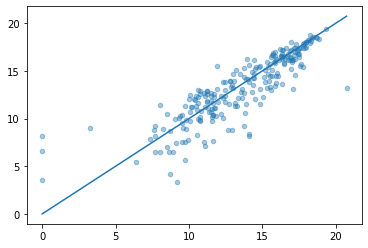

In [156]:
plt.scatter(y_test, model.predict(X_test), alpha=0.4, s=20)
sns.lineplot([0,max(y_test)], [0,max(y_test)])
mean_absolute_error(y_test, model.predict(X_test)), r2_score(y_test, model.predict(X_test))

#sns.scatterplot(np.exp(y_test-1), np.exp(model.predict(X_test)-1))
#sns.lineplot([0,max(np.exp(y_test-1))], [0,max(np.exp(y_test-1))])

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


(1.4265506718638463, 0.6164115625496565)

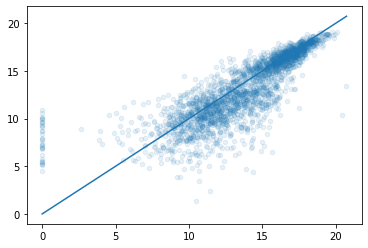

In [154]:
plt.scatter(y_oot, model.predict(X_oot), alpha=0.1, s=20)
sns.lineplot([0,max(y_test)], [0,max(y_test)])
mean_absolute_error(y_oot, model.predict(X_oot)), r2_score(y_oot, model.predict(X_oot))

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


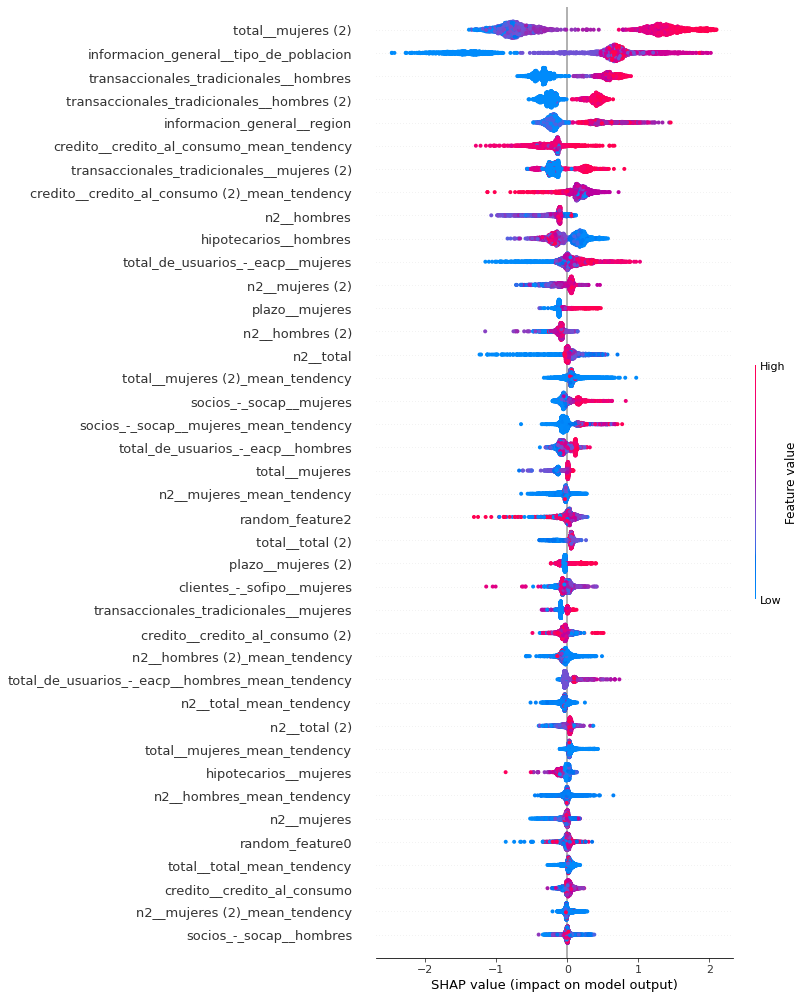

In [144]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_oot, check_additivity=False)
shap_values_df = pd.DataFrame(shap_values, columns=X_oot.columns)
shap.summary_plot(shap_values, X_oot, max_display=40)

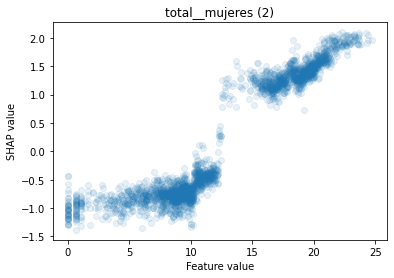

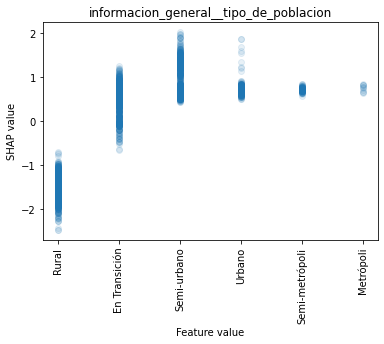

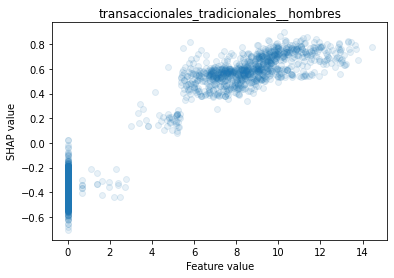

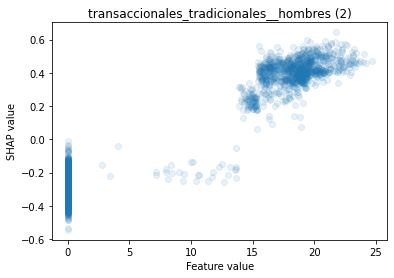

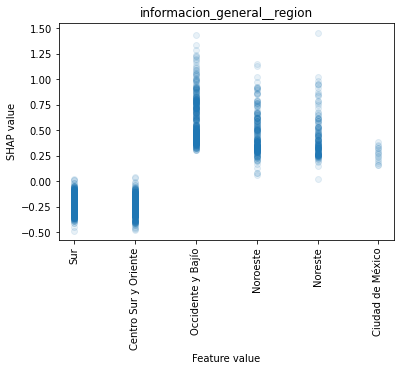

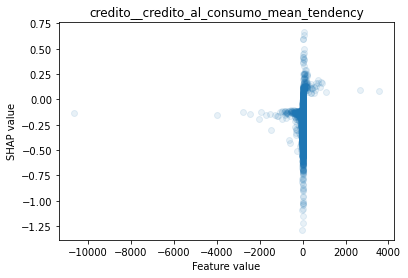

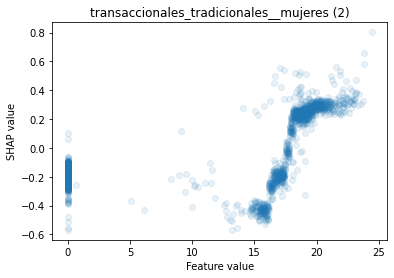

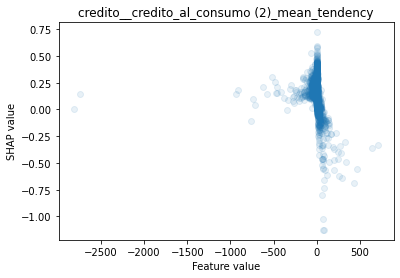

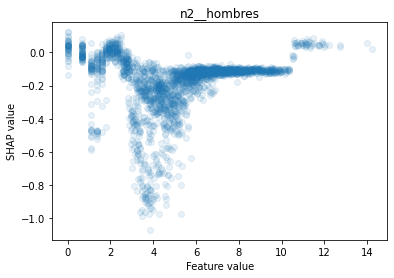

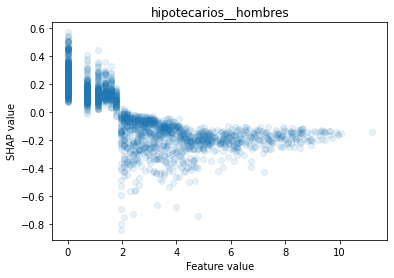

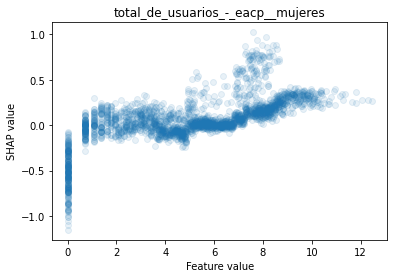

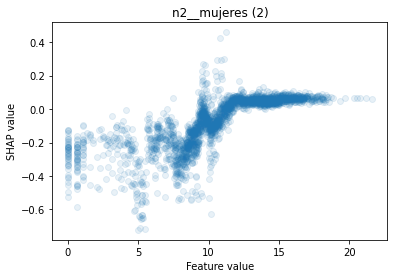

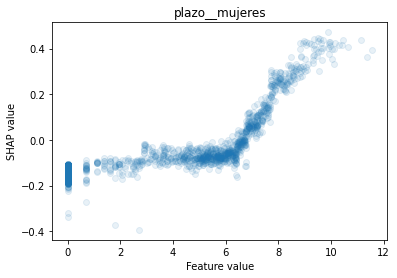

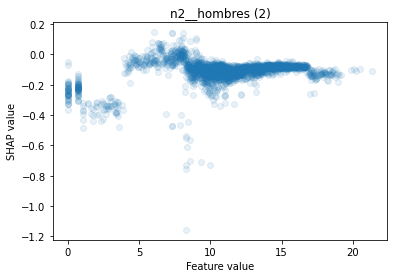

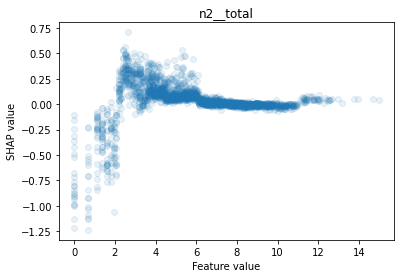

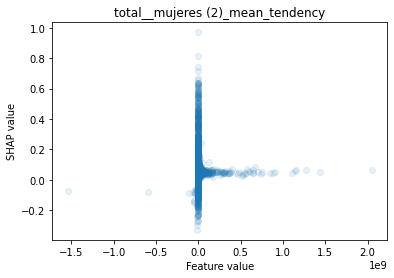

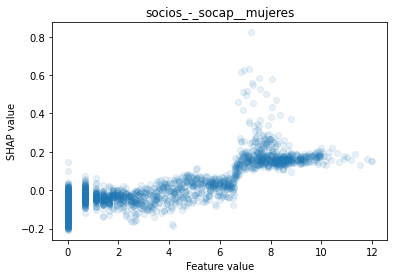

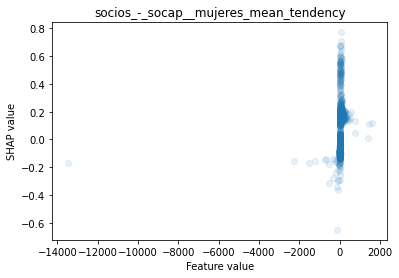

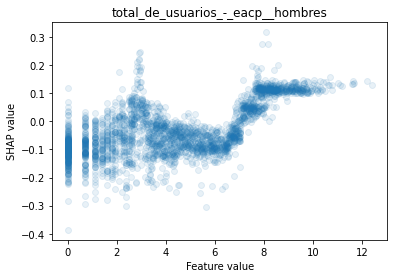

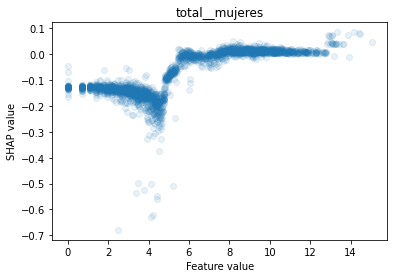

In [163]:
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# make SHAP plots of the three most important features
for i in range(20):
    plt.figure()
    col = X_oot.columns[top_inds[i]]
    plt.scatter(X_oot[col], shap_values_df[col], alpha=0.1)
    plt.title(col)
    plt.xlabel('Feature value')
    plt.ylabel('SHAP value')
    if 'tipo_de_poblacion' in col:
        plt.xticks(list(general_population_type_info.values()), list(general_population_type_info.keys()), rotation=90)
    if 'region' in col:
        plt.xticks(list(general_region_info_dict.values()), list(general_region_info_dict.keys()), rotation=90)
